In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import os
import numpy as np
%load_ext tensorboard

I changed from using Close, to using Open-Close, so I could get the increase/decrease each day. This didn't really help. It scored .3 on train set, and around 0 on test set.

In [2]:
tsla = pd.read_parquet("data/tsla_final2.parquet")

In [3]:
tsla['Change'] = tsla['Open']-tsla['Close']

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0,1))
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler3 = MinMaxScaler(feature_range=(0,1))
scaler4 = MinMaxScaler(feature_range=(0,1))
tsla['subjectivity'] = scaler1.fit_transform(tsla['subjectivity'].values.reshape(-1, 1))
tsla['polarity'] = scaler2.fit_transform(tsla['polarity'].values.reshape(-1, 1))
tsla['Close'] = scaler3.fit_transform(tsla['Close'].values.reshape(-1, 1))
tsla['Change'] = scaler4.fit_transform(tsla['Change'].values.reshape(-1, 1))

In [5]:
actual_prices = tsla['Close'].values.reshape(-1, 1)
actual_prices = scaler3.inverse_transform(actual_prices)
actual_prices

array([[43.86199951],
       [42.01800156],
       [42.25600052],
       ...,
       [86.0759964 ],
       [82.94000244],
       [83.66600037]])

In [151]:
from sklearn.model_selection import train_test_split

X = tsla[['polarity', 'subjectivity']]
y = tsla['Change']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [152]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [153]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X_test, y_test)
best_grid.score(X_train, y_train)

0.40961610653719005

In [154]:
best_grid.score(X_test, y_test)

-0.07943189214464286

Now make Neural Network which uses scores from twitter sentiment

In [155]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

prediction_days = 60

X_train, y_train, X_test, y_test = [], [], [], []
for x in range(prediction_days, len(tsla)-200):
    X_train.append(tsla['Close'].iloc[x-prediction_days:x]) #for each iteration, you get 60 day window (x-60 to x) as training data
    y_train.append(tsla['Close'].iloc[x]) #for each iteration, the label is the last day of window, x

for x in range(len(tsla)-200, len(tsla)):
    X_test.append(tsla['Close'].iloc[x-prediction_days:x])
    y_test.append(tsla['Close'].iloc[x]) 
    
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [156]:
# Create Neural Network
# pip install numpy=1.19.5 may be needed?
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
32/32 [==============================] - 4s 39ms/step - loss: 0.0345
Epoch 2/25
32/32 [==============================] - 1s 39ms/step - loss: 0.0085
Epoch 3/25
32/32 [==============================] - 1s 39ms/step - loss: 0.0078
Epoch 4/25
32/32 [==============================] - 1s 38ms/step - loss: 0.0071
Epoch 5/25
32/32 [==============================] - 1s 36ms/step - loss: 0.0068
Epoch 6/25
32/32 [==============================] - 1s 36ms/step - loss: 0.0071
Epoch 7/25
32/32 [==============================] - 1s 36ms/step - loss: 0.0067
Epoch 8/25
32/32 [==============================] - 1s 37ms/step - loss: 0.0061
Epoch 9/25
32/32 [==============================] - 1s 39ms/step - loss: 0.0058
Epoch 10/25
32/32 [==============================] - 1s 38ms/step - loss: 0.0055
Epoch 11/25
32/32 [==============================] - 1s 37ms/step - loss: 0.0055
Epoch 12/25
32/32 [==============================] - 1s 36ms/step - loss: 0.0055
Epoch 13/25
32/32 [==================

In [158]:
prediction_prices = model.predict(X_train)
prediction_prices = scaler1.inverse_transform(prediction_prices)
prediction_prices

array([[0.15801919],
       [0.15550144],
       [0.15290211],
       [0.15075654],
       [0.15021388],
       [0.15142618],
       [0.15435961],
       [0.15865433],
       [0.16368102],
       [0.16862789],
       [0.17269488],
       [0.1755586 ],
       [0.17710201],
       [0.17750356],
       [0.17694266],
       [0.1760908 ],
       [0.17615126],
       [0.17728482],
       [0.17922471],
       [0.18270794],
       [0.18733738],
       [0.19258237],
       [0.19715512],
       [0.2004405 ],
       [0.20271726],
       [0.20439634],
       [0.205422  ],
       [0.20646341],
       [0.20765208],
       [0.20919277],
       [0.21146117],
       [0.21409999],
       [0.21680261],
       [0.21971434],
       [0.22260968],
       [0.22505072],
       [0.22655164],
       [0.22720996],
       [0.22743261],
       [0.22742772],
       [0.22733098],
       [0.22762291],
       [0.22828192],
       [0.22903864],
       [0.22962242],
       [0.23001553],
       [0.22993378],
       [0.229

array([[43.86199951],
       [42.01800156],
       [42.25600052],
       ...,
       [86.0759964 ],
       [82.94000244],
       [83.66600037]])

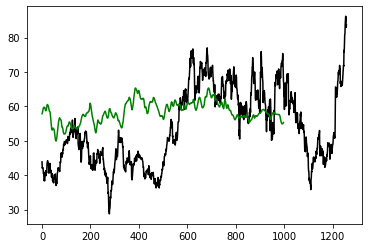

In [140]:
import matplotlib.pyplot as plt
plt.plot(actual_prices, color='black')
plt.plot(prediction_prices, color='green', label='Predicted Prices')

Input predicted change from RF, and 